In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler # StandardScaler

from sklearn.metrics import mean_squared_error

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
j = pd.read_csv('data/J(배).csv', header=0)
j.head()

,date,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
0,2019-10-18 19:48:00,2.287,2.336,0.000,0,136.368,0,0.000,410.256
1,2019-10-18 19:49:00,2.290,2.332,0.000,0,134.696,0,0.000,430.988
2,2019-10-18 19:50:00,2.284,2.336,0.000,0,137.882,0,0.000,440.624
3,2019-10-18 19:51:00,2.290,2.331,0.000,0,138.478,0,0.000,453.675
4,2019-10-18 19:52:00,2.284,2.330,0.000,0,134.451,0,0.000,448.864


In [4]:
j.info(), j.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684763 entries, 0 to 1684762
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   date        1684763 non-null  object 
 1   height1     1684763 non-null  float64
 2   height2     1684763 non-null  float64
 3   in_valve1   1684763 non-null  float64
 4   in_valve2   1684763 non-null  int64  
 5   in_flow     1684763 non-null  float64
 6   out_valve1  1684763 non-null  int64  
 7   out_valve2  1684763 non-null  float64
 8   out_flow    1684763 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 115.7+ MB


(None,
           height1     height2    in_valve1   in_valve2     in_flow  \
 count 1684763.000 1684763.000  1684763.000 1684763.000 1684763.000   
 mean        2.833       2.957     7651.998     150.048     334.790   
 std         0.851       0.618   874445.828   17147.015     152.779   
 min         0.000       0.000        0.000       0.000    -966.718   
 25%         2.713       2.762        0.000       0.000     259.000   
 50%         3.031       3.049        0.000       0.000     300.200   
 75%         3.313       3.316        0.000       0.000     367.000   
 max         4.019       4.069 99936460.000 1959678.000    2113.655   
 
        out_valve1   out_valve2    out_flow  
 count 1684763.000  1684763.000 1684763.000  
 mean       74.439     6594.258     304.030  
 std      8506.669   753570.709      98.444  
 min         0.000        0.000    -119.992  
 25%         0.000        0.000     231.979  
 50%         0.000        0.000     308.723  
 75%         0.000        0.00

In [5]:
j['date'] = pd.to_datetime(j['date'])
j.set_index('date', inplace=True)

In [6]:
j.loc[j['height1'] <= 1, 'height1'] = np.nan

In [7]:
# median_value = j['height1'].median()
# j['height1'] = j['height1'].fillna(median_value)
mean_value = j['height1'].mean()
j['height1'] = j['height1'].fillna(mean_value)

In [8]:
j.loc[j['height2'] <= 1, 'height2'] = np.nan

In [9]:
# median_value = j['height2'].median()
# j['height2'] = j['height2'].fillna(median_value)
mean_value = j['height2'].mean()
j['height2'] = j['height2'].fillna(mean_value)

In [10]:
j.loc[(j['in_flow'] > 800), 'in_flow'] = np.nan

In [11]:
j['in_flow'] = j['in_flow'].interpolate(method='linear')
# mean = j['in_flow'].mean()
# j['in_flow'] = j['in_flow'].fillna(mean)
# median_value = j['in_flow'].median()
# j['in_flow'] = j['in_flow'].fillna(median_value)

In [12]:
j.loc[(j['in_flow'] < 0), 'in_flow'] = np.nan

In [13]:
j['in_flow'] = j['in_flow'].ffill()

In [14]:
j.loc[(j['out_flow'] > 800) , 'out_flow'] = np.nan

In [15]:
j['out_flow'] = j['out_flow'].interpolate(method='linear')
# mean = j['out_flow'].mean()
# j['out_flow'] = j['out_flow'].fillna(mean)
# median_value = j['out_flow'].median()
# j['out_flow'] = j['out_flow'].fillna(median_value)

In [16]:
j.loc[(j['in_flow'] < 0), 'out_flow'] = np.nan

In [17]:
j['out_flow'] = j['out_flow'].ffill()

In [18]:
j.describe()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
count,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000
mean,3.043,3.037,7651.998,150.048,325.797,74.439,6594.258,304.026
std,0.382,0.383,874445.828,17147.015,115.984,8506.669,753570.709,98.429
min,1.001,1.001,0.000,0.000,0.000,0.000,0.000,-119.992
25%,2.816,2.796,0.000,0.000,258.900,0.000,0.000,231.978
50%,3.043,3.049,0.000,0.000,300.000,0.000,0.000,308.722
75%,3.313,3.316,0.000,0.000,366.100,0.000,0.000,369.000
max,4.019,4.069,99936460.000,1959678.000,800.000,972199.000,86124350.000,722.570


In [19]:
j = j.resample('h').mean()
j.head(), j.tail()

(                     height1  height2  in_valve1  in_valve2  in_flow  \
 date                                                                   
 2019-10-18 19:00:00    2.278    2.325      0.000      0.000  135.767   
 2019-10-18 20:00:00    2.325    2.368      0.000      0.000  451.579   
 2019-10-18 21:00:00    2.387    2.424      0.000      0.000  285.715   
 2019-10-18 22:00:00    2.389    2.421      0.000      0.000  269.691   
 2019-10-18 23:00:00    2.376    2.408      0.000      0.000  175.643   
 
                      out_valve1  out_valve2  out_flow  
 date                                                   
 2019-10-18 19:00:00       0.000       0.000   444.767  
 2019-10-18 20:00:00       0.000       0.000   352.897  
 2019-10-18 21:00:00       0.000       0.000   426.186  
 2019-10-18 22:00:00       0.000       0.000   336.389  
 2019-10-18 23:00:00       0.000       0.000   320.777  ,
                      height1  height2  in_valve1  in_valve2  in_flow  \
 date         

In [20]:
j.isna().sum()

height1       0
height2       0
in_valve1     0
in_valve2     0
in_flow       0
out_valve1    0
out_valve2    0
out_flow      0
dtype: int64

In [21]:
start_date = pd.Timestamp('2019-10-18 20:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:00')

# 주어진 기간 내의 데이터를 sample로 설정
sample_df = j[(j.index >= start_date) & (j.index <= end_date)]

sample_df

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
date,,,,,,,,
2019-10-18 20:00:00,2.325,2.368,0.000,0.000,451.579,0.000,0.000,352.897
2019-10-18 21:00:00,2.387,2.424,0.000,0.000,285.715,0.000,0.000,426.186
2019-10-18 22:00:00,2.389,2.421,0.000,0.000,269.691,0.000,0.000,336.389
2019-10-18 23:00:00,2.376,2.408,0.000,0.000,175.643,0.000,0.000,320.777
2019-10-19 00:00:00,2.416,2.464,0.000,0.000,381.217,0.000,0.000,293.171
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,3.129,3.114,0.000,0.000,245.008,0.000,0.000,406.098
2022-06-30 20:00:00,2.987,2.977,0.000,0.000,244.290,0.000,0.000,434.142
2022-06-30 21:00:00,2.836,2.830,0.000,0.000,245.970,0.000,0.000,428.195


In [22]:
train_start = start_date
train_end = pd.Timestamp('2021-08-31 23:00:00')
val_start = pd.Timestamp('2021-09-01 00:00:00')
val_end = pd.Timestamp('2022-01-31 23:00:00')
test_start = pd.Timestamp('2022-02-01 00:00:00')
test_end = end_date

In [23]:
train_set = sample_df.loc[train_start:train_end]
val_set = sample_df.loc[val_start:val_end]
test_set = sample_df.loc[test_start:test_end]

train_set.shape, val_set.shape, test_set.shape

((16396, 8), (3672, 8), (3600, 8))

In [24]:
# NaN 값 확인
print("NaN values in train_data before scaling:", train_set.isna().sum().sum())
print("NaN values in val_data before scaling:", val_set.isna().sum().sum())
print("NaN values in test_data before scaling:", test_set.isna().sum().sum())

NaN values in train_data before scaling: 0
NaN values in val_data before scaling: 0
NaN values in test_data before scaling: 0


In [25]:
features = ['height1', 'height2', 'in_flow']
target = 'out_flow'

In [26]:
train_features = train_set[features]
train_target = train_set[[target]]
val_features = val_set[features]
val_target = val_set[[target]]
test_features = test_set[features]
test_target = test_set[[target]]

print(f'train_features의 shape', train_features.shape)
print(f'train_target의 shape', train_target.shape)
print(f'val_features의 shape', val_features.shape)
print(f'val_target의 shape', val_target.shape)
print(f'test_features의 shape', test_features.shape)
print(f'test_target의 shape', test_target.shape)

train_features의 shape (16396, 3)
train_target의 shape (16396, 1)
val_features의 shape (3672, 3)
val_target의 shape (3672, 1)
test_features의 shape (3600, 3)
test_target의 shape (3600, 1)


In [27]:
ft_scaler = MinMaxScaler()
tg_scaler = MinMaxScaler()

scaled_train_features = ft_scaler.fit_transform(train_features)
scaled_train_target = tg_scaler.fit_transform(train_target)

scaled_val_features = ft_scaler.transform(val_features)
scaled_val_target = tg_scaler.transform(val_target)

scaled_test_features = ft_scaler.transform(test_features)
scaled_test_target = tg_scaler.transform(test_target)

In [28]:
def create_sequences(features, target, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 24
X_train, y_train = create_sequences(scaled_train_features, scaled_train_target, seq_length)
X_val, y_val = create_sequences(scaled_val_features, scaled_val_target, seq_length)
X_test, y_test = create_sequences(scaled_test_features, scaled_test_target, seq_length)

In [29]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [30]:
class OutFlowPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(OutFlowPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=n_features, out_channels=16, kernel_size=2, stride=1)  # 1D CNN 레이어 추가

        self.lstm = nn.LSTM(
            input_size=16,  # CNN 레이어 출력 크기
            hidden_size=n_hidden,  # 기억하고 있는 정보량
            num_layers=n_layers,
            batch_first=True
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self, batch_size):  # LSTM 레이어 은닉 상태 초기화
        self.hidden = (
            torch.zeros(self.n_layers, batch_size, self.n_hidden),
            torch.zeros(self.n_layers, batch_size, self.n_hidden)
        )

    def forward(self, sequences):
        batch_size = sequences.size(0)
        self.reset_hidden_state(batch_size)
        sequences = self.c1(sequences.permute(0, 2, 1))  # CNN에 입력하기 전 변환
        sequences = torch.relu(sequences)  # 활성화 함수 추가
        lstm_out, self.hidden = self.lstm(sequences.permute(0, 2, 1), self.hidden)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

In [31]:
model = OutFlowPredictor(
    n_features = len(features),  # height1, height2, in_flow
    n_hidden = 50,
    seq_len = seq_length,
    n_layers = 1
)

In [32]:
# 데이터셋 및 데이터로더 설정
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64  # 배치 크기 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
def train_model(model, train_loader, val_loader, num_epochs=100, verbose = 10, patience = 10):
    train_hist = []
    val_hist = []

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        total_loss = 0.0
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X, batch_y
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val, batch_y_val
                predictions_val = model(batch_X_val)
                val_loss = loss_fn(predictions_val, batch_y_val)
                total_val_loss += val_loss.item()

            average_val_loss = total_val_loss / len(val_loader)
            val_hist.append(average_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

    return train_hist, val_hist

In [35]:
train_hist, val_hist = train_model(
    model, train_loader, val_loader,
    num_epochs=50, 
    verbose=10,
    patience = 10)

Epochs:  20%|██        | 10/50 [00:12<00:49,  1.25s/it]

Epoch [10/50] - Training Loss: 0.0121, Validation Loss: 0.0093


Epochs:  40%|████      | 20/50 [00:24<00:37,  1.26s/it]

Epoch [20/50] - Training Loss: 0.0106, Validation Loss: 0.0091


Epochs:  60%|██████    | 30/50 [00:37<00:25,  1.30s/it]

Epoch [30/50] - Training Loss: 0.0098, Validation Loss: 0.0089


Epochs:  80%|████████  | 40/50 [00:50<00:12,  1.26s/it]

Epoch [40/50] - Training Loss: 0.0092, Validation Loss: 0.0098


Epochs: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]

Epoch [50/50] - Training Loss: 0.0086, Validation Loss: 0.0081


In [36]:
model.eval()
with torch.no_grad():
    predictions = []
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test
        prediction = model(batch_X_test)
        predictions.extend(prediction.numpy())

    predictions = np.array(predictions)
    predictions = tg_scaler.inverse_transform(predictions.reshape(-1, 1))
    actuals = tg_scaler.inverse_transform(y_test.numpy())

In [40]:
# RMSE 계산
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Conv1D + LSTM RMSE: {rmse:.4f}')

Conv1D + LSTM RMSE: 47.4010


In [41]:
# 테스트 구간의 날짜를 가져오기
dates = test_set.index[seq_length:]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': actuals.flatten(),
    'Predicted': predictions.flatten()
})

print(comparison_df)

                    Date  Actual  Predicted
0    2022-02-02 00:00:00 240.439    251.803
1    2022-02-02 01:00:00 190.733    211.051
2    2022-02-02 02:00:00 160.002    178.809
3    2022-02-02 03:00:00 154.900    156.804
4    2022-02-02 04:00:00 188.788    153.454
...                  ...     ...        ...
3571 2022-06-30 19:00:00 406.098    392.803
3572 2022-06-30 20:00:00 434.142    397.817
3573 2022-06-30 21:00:00 428.195    391.715
3574 2022-06-30 22:00:00 364.893    349.034
3575 2022-06-30 23:00:00 312.118    292.884

[3576 rows x 3 columns]


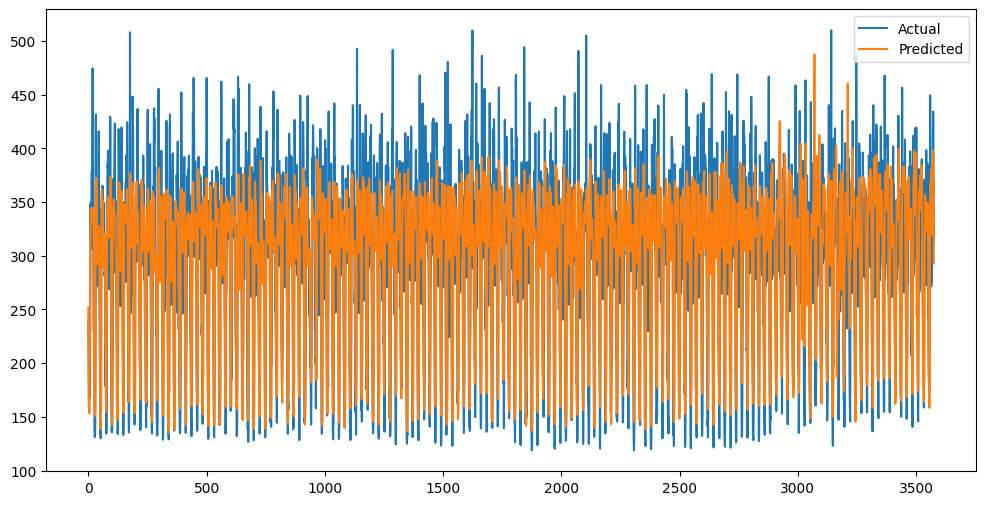

In [42]:
# 결과 출력
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()